![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Advanced Methods in Natural Language Processing - Session 4

# Text Classification with AG News Corpus

This notebook will guide you through different approaches to text classification using the AG News corpus. We will start with a simple baseline model and gradually move towards more complex and sophisticated models.

## Table of Contents

1. **[Part 1: Baseline Pipeline with TF-IDF and Linear Model](#part1)**
   - 1.1. Loading and Exploring Data
   - 1.2. Feature Extraction with TF-IDF
   - 1.3. Training a Linear Model
   - 1.4. Model Evaluation

2. **[Part 2: LSTM Pipeline with One-Hot Encoding](#part2)**
   - 2.1. Preprocessing for LSTM
   - 2.2. Building a Bidirectional LSTM Model
   - 2.3. Training the LSTM Model
   - 2.4. Model Evaluation

3. **[Part 3: Word Embedding Add-Ons with Word2Vec](#part3)**
   - 3.1. Loading Pre-trained Word2Vec Embeddings
   - 3.2. Integrating Word2Vec into LSTM Model
   - 3.3. Training and Evaluating the Model

4. **[Part 4: Training Custom Embeddings with Gensim](#part4)**
   - 4.1. Training Word2Vec/FastText with Gensim
   - 4.2. Building a Model with Custom Embeddings
   - 4.3. Model Training and Evaluation
   - 4.4. Compar embeddings before / after finetuning

## Part 0: Metrics Functions to Consider

Before diving into the model building and training, it's crucial to establish the metrics we'll use to evaluate our models. In this part, we will define and discuss the different metrics functions that are commonly used in NLP tasks, particularly for text classification:

1. **Accuracy**: Measures the proportion of correct predictions among the total number of cases examined. It's a straightforward metric but can be misleading if the classes are imbalanced.

2. **Precision and Recall**: Precision measures the proportion of positive identifications that were actually correct, while recall measures the proportion of actual positives that were identified correctly. These metrics are especially important when dealing with imbalanced datasets.

3. **F1 Score**: The harmonic mean of precision and recall. It's a good way to show that a classifer has a good balance between precision and recall.

4. **Confusion Matrix**: A table used to describe the performance of a classification model on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm.

5. **ROC and AUC**: The receiver operating characteristic curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system. The area under the curve (AUC) represents measure of separability.

We will implement these metrics functions using libraries such as scikit-learn, and they will be used to assess and compare the performance of our different models throughout this exercise.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='macro'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot each metric
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            ax = axs[i//2, i%2]
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)
            ax.set_ylim(0, 100)

            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

## Part 1: Baseline Pipeline with TF-IDF and Linear Model

In this part, we will create a baseline model for text classification. This involves:

### 1. **Loading and Exploring Data**:

We will load the AG News corpus and perform necessary preprocessing steps like exploring the dataset.

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.8 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

# Load the 'ag_news' dataset
dataset = load_dataset("ag_news")

# Explore the structure of the dataset
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


Let's create stratified samples for training and validation sets ensuring that each class is represented in proportion to its frequency. It will go faster with just a sample, and we will be able to make tests on validation test before trying to work on the testing set.

In [ ]:
from sklearn.model_selection import train_test_split

data = dataset['train']['text']
labels = dataset['train']['label']

test_data = dataset['test']['text']
test_labels = dataset['test']['label']

# Stratified split to create a smaller training and validation set
train_data, valid_data, train_labels, valid_labels = train_test_split(
    data, labels, stratify=labels, test_size=0.2, random_state=42
)

# Further split to get 10k and 2k samples respectively
train_data, _, train_labels, _ = train_test_split(
    train_data, train_labels, stratify=train_labels, train_size=10000, random_state=42
)
valid_data, _, valid_labels, _ = train_test_split(
    valid_data, valid_labels, stratify=valid_labels, train_size=2000, random_state=42
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


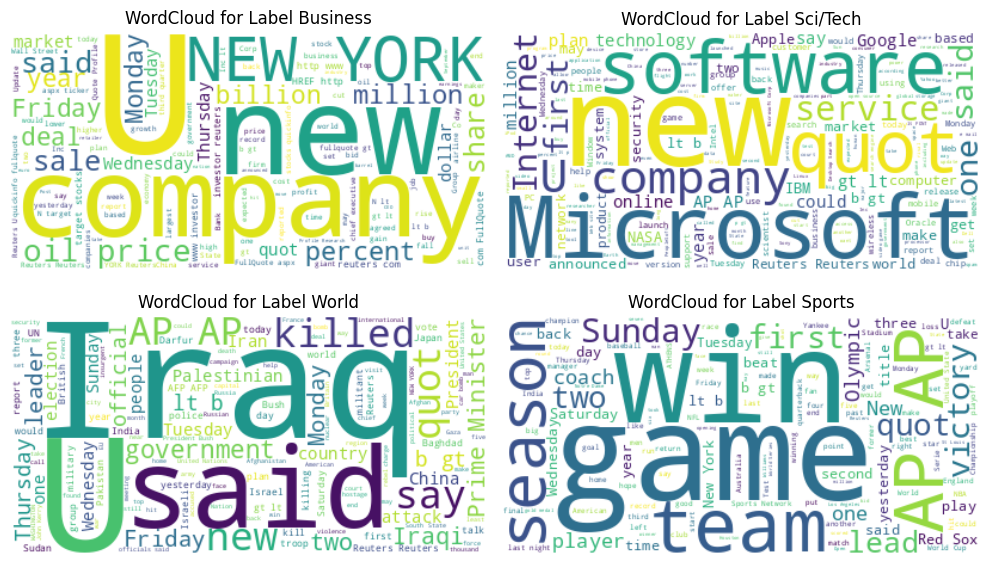

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

labels = {0: 'World', 1: 'Sports',
          2: 'Business', 3: 'Sci/Tech'}

# Prepare data for wordclouds
label_data = defaultdict(lambda: '')

for text, label in zip(train_data, train_labels):
    label_data[label] += text

# Generate and plot wordclouds for each label
fig, axs = plt.subplots(2, 2, figsize=(10, 6))  # Create 2x2 subplots
axs = axs.flatten()  # Flatten the axis array

for ax, (label, text) in zip(axs, label_data.items()):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('WordCloud for Label {}'.format(labels.get(label)))
    ax.axis('off')

plt.tight_layout()
plt.show()

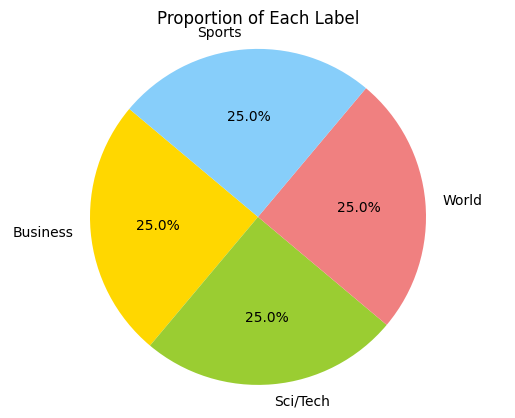

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the frequency of each label
label_counts = Counter(train_labels)

# Data to plot
_labels = [labels.get(lab) for lab in label_counts.keys()]
sizes = label_counts.values()
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']

# Plotting the pie chart
plt.pie(sizes, labels=_labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportion of Each Label')
plt.show()


### 2. **Feature Extraction with TF-IDF**:

We will convert the text data into numerical form using the TF-IDF vectorization technique. We will use the `Pipeline` class from scikit-learn which is really practical.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Create a pipeline with TF-IDF and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2),
                              min_df=5,
                              stop_words='english')),
    ('clf', LogisticRegression(solver='liblinear')),
])

# Fit the pipeline on the training data
pipeline.fit(train_data, train_labels)

valid_preds = pipeline.predict(valid_data)

In [ ]:
metrics_val= Metrics()
metrics_val.run(valid_labels, valid_preds, "basic TF-IDF")

### 3. **Training with Cross Validation**:

We will train a linear classifier (such as Logistic Regression) using the extracted features, `Pipeline` module and cross validation with `GridSearchCV`.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'tfidf__min_df': [1, 2, 5],  # Example values, you can choose others
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2)]  # Unigrams, bigrams or both
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(train_data, train_labels)

# Best parameters found by grid search
print(f'Best Parameters: {grid_search.best_params_}')

# Evaluate on the validation set
valid_preds = grid_search.predict(valid_data)
metrics_val.run(valid_labels, valid_preds, "CV-ed TF-IDF")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3)}


### 4. **Model Evaluation**:

We will evaluate the performance of our model on a separate test set using various metrics.

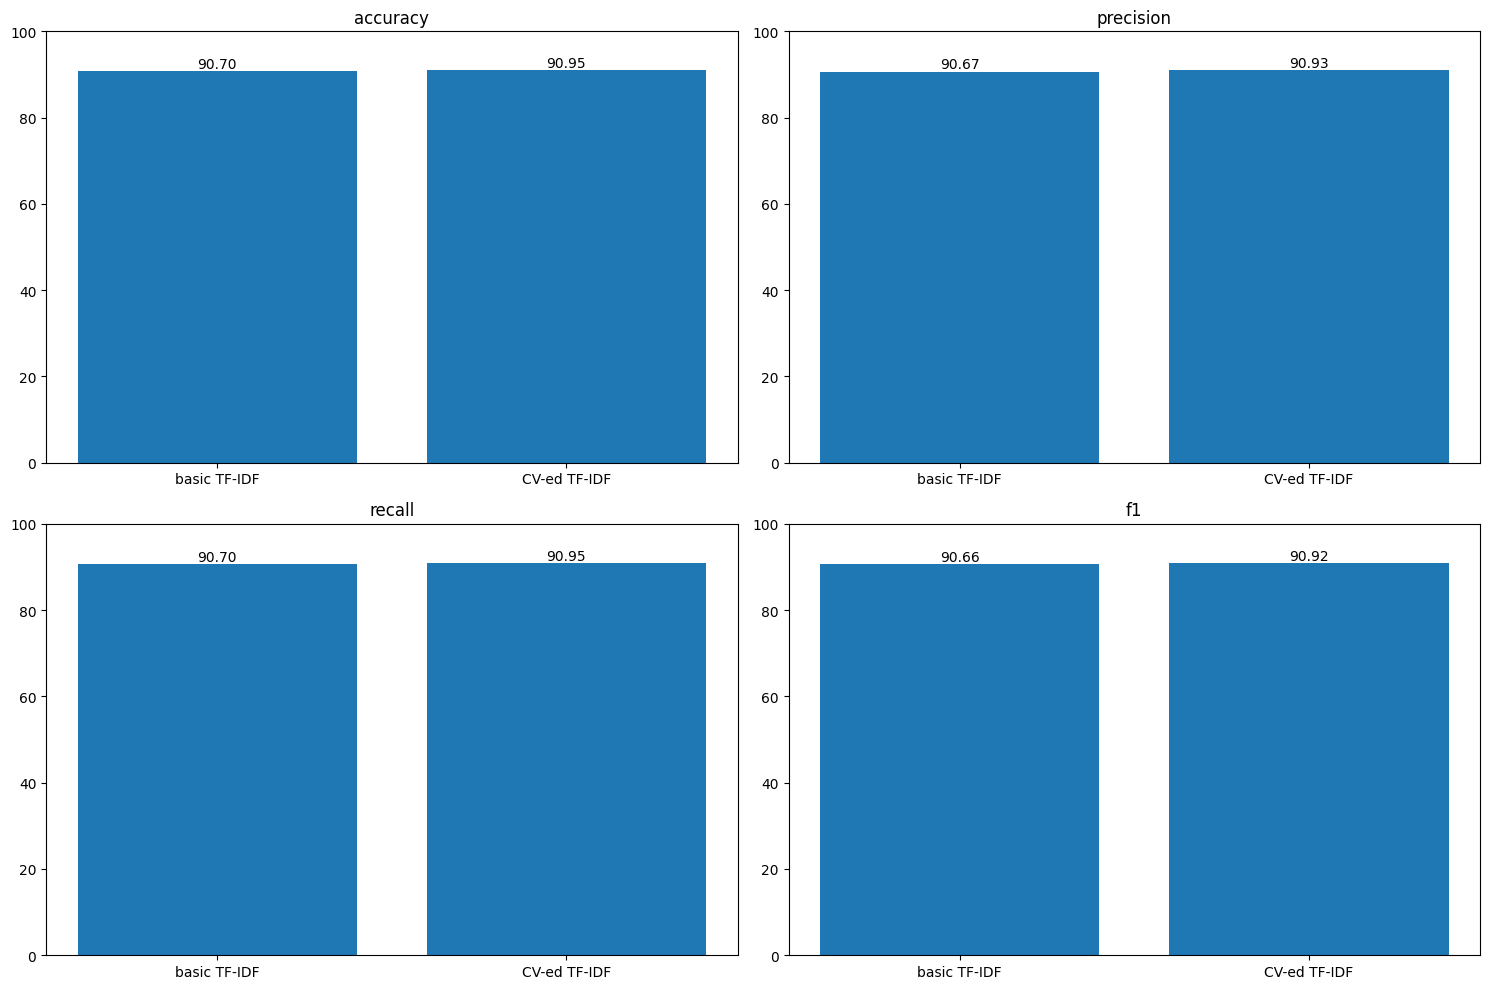

In [ ]:
metrics_val.plot()

## Part 2: LSTM Pipeline with One-Hot Encoding

In this part, we'll explore a more complex model using LSTM:

### 1. **Preprocessing for LSTM**:

We'll prepare the text data for LSTM, which involves tokenization and converting words to one-hot encoded vectors.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Parameters
vocab_size = 5000  # This is a hyperparameter, adjust as needed
max_length = 128    # This is another hyperparameter

# Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_data)

# Convert texts to sequences of integers
sequences_train = tokenizer.texts_to_sequences(train_data)
sequences_valid = tokenizer.texts_to_sequences(valid_data)

# Pad sequences to the same length
padded_sequences_train = pad_sequences(sequences_train, maxlen=max_length,
                                 padding='post', truncating='post')
padded_sequences_valid = pad_sequences(sequences_valid, maxlen=max_length,
                                 padding='post', truncating='post')


# Assuming train_labels are integer labels
num_classes = len(set(train_labels))  # Determine the number of unique classes

# Convert labels to one-hot vectors
train_labels_lstm = to_categorical(train_labels, num_classes=num_classes)
valid_labels_lstm = to_categorical(valid_labels, num_classes=num_classes)

### 2. **Building a Bidirectional LSTM Model**:

We'll design a neural network with a Bidirectional LSTM layer to capture context from both directions in the text.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.metrics import Precision, Recall

model = Sequential([
    Embedding(vocab_size, output_dim=64, input_length=max_length),
    Bidirectional(LSTM(64)),  # First bidirectional LSTM layer
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 64)           320000    
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 386564 (1.47 MB)
Trainable params: 386564 (1.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 3. **Training the LSTM Model**:

We'll train our LSTM model on the preprocessed text data.


In [ ]:
history = model.fit(
    padded_sequences_train,
    train_labels_lstm,
    epochs=10,
    batch_size=128,
    validation_data=(padded_sequences_valid, valid_labels_lstm)
)

Epoch 1/10
79/79 [==============================] - 33s 362ms/step - loss: 1.1699 - accuracy: 0.5691 - precision: 0.8992 - recall: 0.0919 - val_loss: 0.9098 - val_accuracy: 0.7105 - val_precision: 0.9628 - val_recall: 0.3110
Epoch 2/10
79/79 [==============================] - 28s 354ms/step - loss: 0.5407 - accuracy: 0.8489 - precision: 0.9164 - recall: 0.6995 - val_loss: 0.4151 - val_accuracy: 0.8695 - val_precision: 0.9026 - val_recall: 0.8245
Epoch 3/10
79/79 [==============================] - 29s 362ms/step - loss: 0.2977 - accuracy: 0.9063 - precision: 0.9277 - recall: 0.8873 - val_loss: 0.3593 - val_accuracy: 0.8800 - val_precision: 0.9025 - val_recall: 0.8515
Epoch 4/10
79/79 [==============================] - 29s 367ms/step - loss: 0.2089 - accuracy: 0.9395 - precision: 0.9503 - recall: 0.9271 - val_loss: 0.3563 - val_accuracy: 0.8770 - val_precision: 0.8946 - val_recall: 0.8575
Epoch 5/10
79/79 [==============================] - 27s 348ms/step - loss: 0.1539 - accuracy: 0.9594

### 4. **Model Evaluation**:

*Similar* to Part 1, we will evaluate our model's performance using appropriate metrics.


In [ ]:
predictions = model.predict(padded_sequences_valid)
valid_preds = np.argmax(predictions, axis=1)
metrics_val.run(valid_labels, valid_preds, "BiLSTM")

63/63 [==============================] - 3s 27ms/step


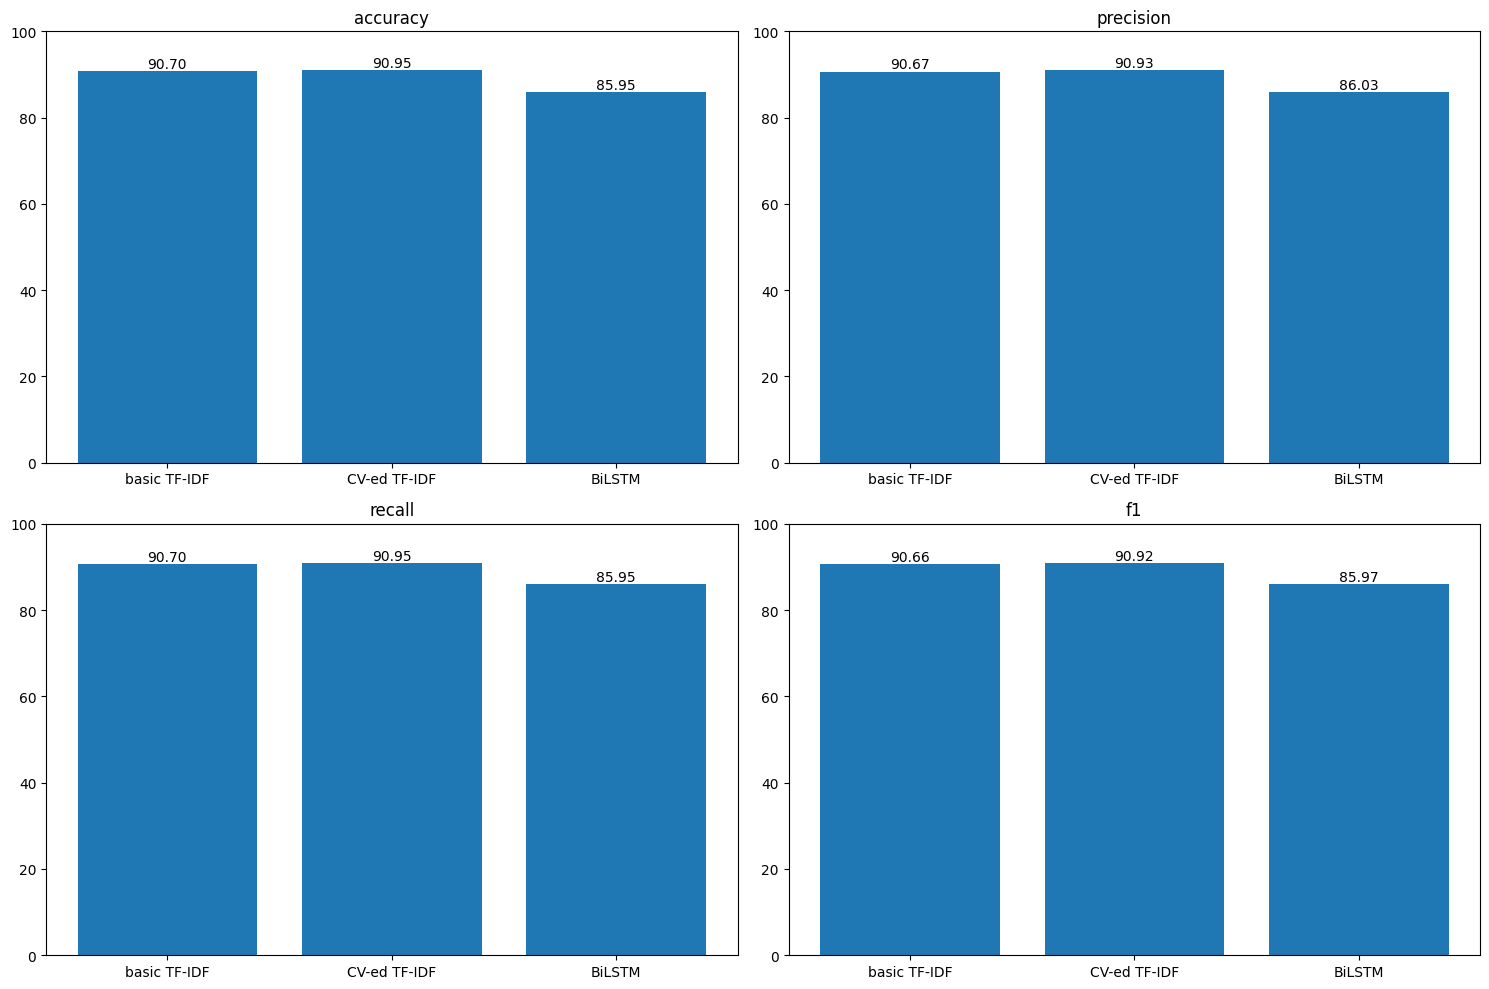

In [ ]:
metrics_val.plot()

## Part 3: Word Embedding Add-Ons with Word2Vec

This part focuses on integrating pre-trained word embeddings into our model.

## 1. **Loading Pre-trained Word2Vec Embeddings**:

We'll load Word2Vec embeddings pre-trained on a large corpus.

In [ ]:
import gensim.downloader as api

# Download the model
word2vec_model = api.load("word2vec-google-news-300")

# Check that it's been downloaded
print(word2vec_model)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
KeyedVectors<vector_size=300, 3000000 keys>


## 2. **Integrating Word2Vec into LSTM Model**:
We'll use these embeddings as inputs to our LSTM model, potentially enhancing its ability to understand context and semantics.

In [ ]:
import numpy as np

# Initialize the embedding matrix
embedding_matrix = np.zeros((vocab_size, 300))  # 300 is the dimensionality of GoogleNews vectors

for word, i in tokenizer.word_index.items():
    if word in word2vec_model:
        if i < vocab_size:
            embedding_vector = word2vec_model[word]
            embedding_matrix[i] = embedding_vector

# Define the model

model = Sequential([
    Embedding(vocab_size, 300, weights=[embedding_matrix],
              input_length=max_length, trainable=False),  # Set trainable to False
    Bidirectional(LSTM(64)),  # First bidirectional LSTM layer
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 128, 300)          1500000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               186880    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 1687396 (6.44 MB)
Trainable params: 187396 (732.02 KB)
Non-trainable params: 1500000 (5.72 MB)
_________________________________________________________________


## 3. **Training and Evaluating the Model**:
We'll train our model with these new embeddings and evaluate to see if there's an improvement in performance.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Setup early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # How many epochs to wait after min has been hit
    verbose=1,  # Verbosity level
    mode='min',  # Mode for the monitored quantity (minimizing loss)
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)


history = model.fit(
    padded_sequences_train,
    train_labels_lstm,
    epochs=10,
    batch_size=128,
    validation_data=(padded_sequences_valid, valid_labels_lstm),
    callbacks=[early_stopping]
)


Epoch 1/10
79/79 [==============================] - 77s 870ms/step - loss: 0.6922 - accuracy: 0.7781 - val_loss: 0.4117 - val_accuracy: 0.8570
Epoch 2/10
79/79 [==============================] - 72s 918ms/step - loss: 0.3837 - accuracy: 0.8722 - val_loss: 0.3756 - val_accuracy: 0.8690
Epoch 3/10
79/79 [==============================] - 53s 672ms/step - loss: 0.3443 - accuracy: 0.8830 - val_loss: 0.3605 - val_accuracy: 0.8730
Epoch 4/10
79/79 [==============================] - 40s 506ms/step - loss: 0.3228 - accuracy: 0.8893 - val_loss: 0.3434 - val_accuracy: 0.8785
Epoch 5/10
79/79 [==============================] - 39s 493ms/step - loss: 0.3079 - accuracy: 0.8946 - val_loss: 0.3577 - val_accuracy: 0.8745
Epoch 6/10
79/79 [==============================] - 39s 490ms/step - loss: 0.2884 - accuracy: 0.9010 - val_loss: 0.3350 - val_accuracy: 0.8775
Epoch 7/10
79/79 [==============================] - 38s 487ms/step - loss: 0.2774 - accuracy: 0.9048 - val_loss: 0.3520 - val_accuracy: 0.8790

## 4. **Model Evaluation**:

Similar to previous parts, we will evaluate our model's performance using appropriate metrics.


63/63 [==============================] - 5s 73ms/step


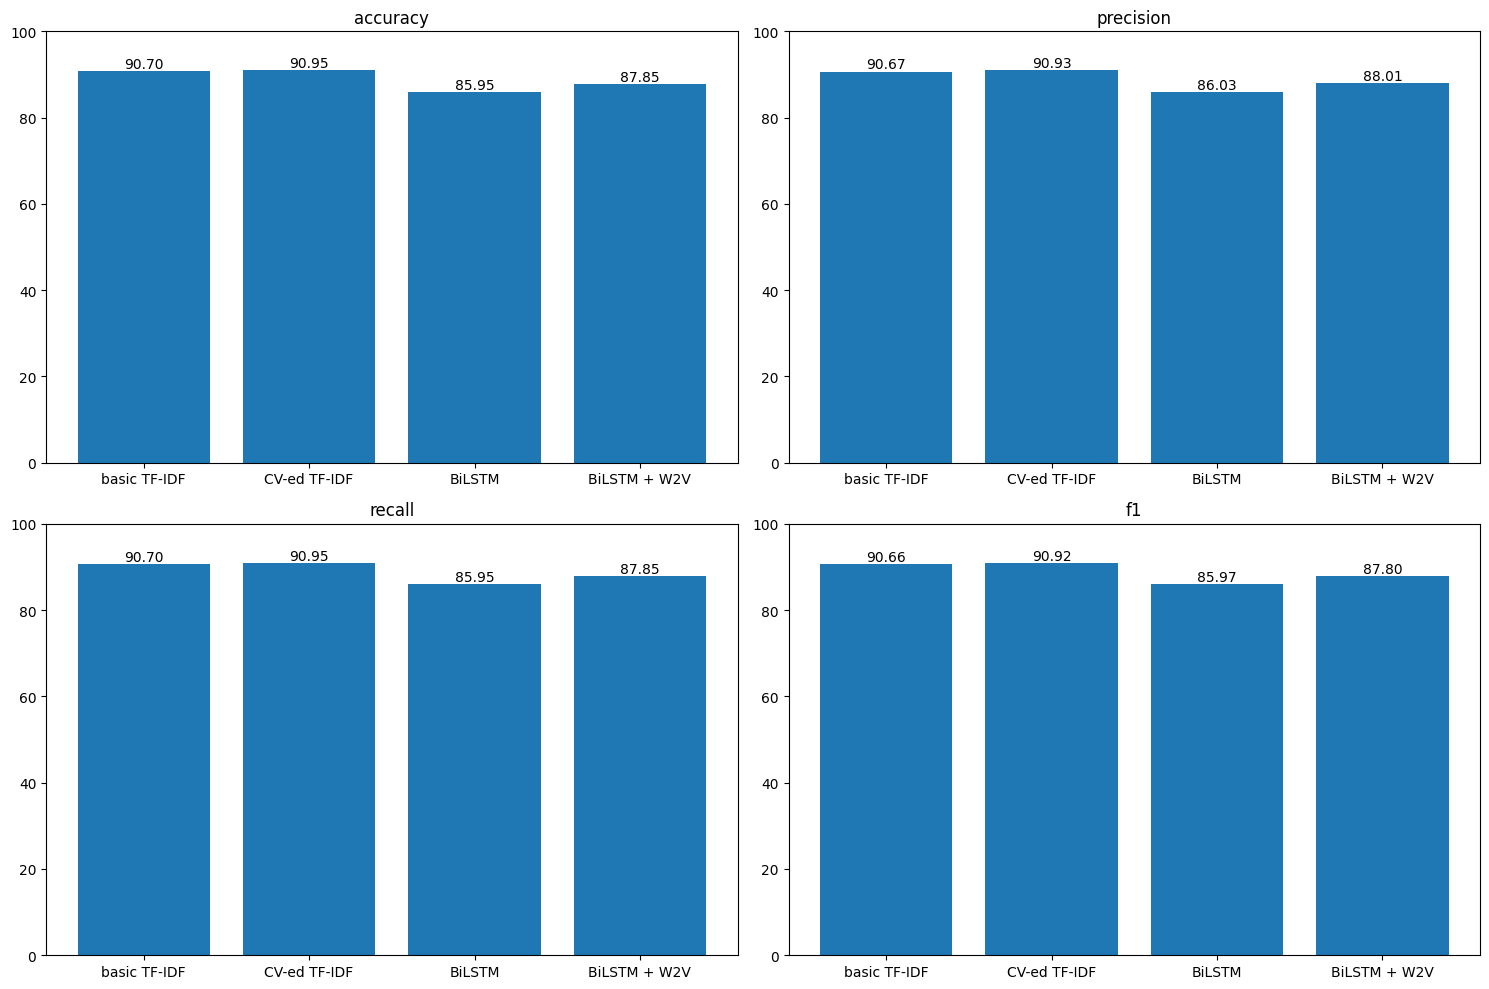

In [ ]:
predictions = model.predict(padded_sequences_valid)
valid_preds = np.argmax(predictions, axis=1)
metrics_val.run(valid_labels, valid_preds, "BiLSTM + W2V")
metrics_val.plot()

## Part 4: Training Custom Embeddings with Gensim

In this final part, we'll train our own word embeddings using the Gensim library:

### 1. **Training Word2Vec/FastText with Gensim**:

We'll use the Gensim library to train Word2Vec or FastText embeddings on our corpus.

In [ ]:
from gensim.models import Word2Vec

# Initialize model
my_model = Word2Vec(vector_size=300, min_count=1)  # size should match the dimensionality of pre-trained vectors

# Build vocabulary from your corpus
my_model.build_vocab(sequences_train)

# Update vocabulary with pre-trained model
my_model.build_vocab([list(word2vec_model.key_to_index)], update=True)

sequences_train_words = [[tokenizer.index_word[i] for i in seq] for seq in sequences_train]

# Fine-tune the model on your data
my_model.train(sequences_train_words, total_examples=len(sequences_train_words), epochs=5)

### 2. **Building a Model with Custom Embeddings**:

We'll integrate these custom-trained embeddings into a new LSTM model.

In [ ]:
# Initialize the embedding matrix
embedding_matrix = np.zeros((vocab_size, 300))  # Ensure this matches the dimensionality of your Word2Vec embeddings

# Fill in the matrix
for word, i in tokenizer.word_index.items():
    if word in my_model.wv and i < vocab_size:
        embedding_vector = my_model.wv[word]
        embedding_matrix[i] = embedding_vector

model = Sequential([
    Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=True),  # Set trainable as needed
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

### 3. **Model Training and Evaluation**:

We'll train this model and evaluate its performance, comparing it with the models from previous parts.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Setup early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # How many epochs to wait after min has been hit
    verbose=1,  # Verbosity level
    mode='min',  # Mode for the monitored quantity (minimizing loss)
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)


history = model.fit(
    padded_sequences_train,
    train_labels_lstm,
    epochs=10,
    batch_size=128,
    validation_data=(padded_sequences_valid, valid_labels_lstm),
    callbacks=[early_stopping]
)


In [ ]:
predictions = model.predict(padded_sequences_valid)
valid_preds = np.argmax(predictions, axis=1)
metrics_val.run(valid_labels, valid_preds, "BiLSTM + fine-tuned W2V")
metrics_val.plot()

### 4. Compare the embedding

We'll plot the embeddings after and before we fine-tuned on our dataset.

**Select Words for Visualization**

First, select a subset of words that you want to visualize. It's often insightful to choose words that are thematically related or words for which you expect interesting relationships or changes due to fine-tuning.

In [ ]:
# List of words you want to visualize
words = ['compagny', 'news', 'game', 'win', 'kill', 'software', 'share', 'official']

# Extract their vectors from your model
word_vectors = np.array([my_model.wv[word] for word in words if word in my_model.wv])
w2v = np.array([word2vec_model[word] for word in words if word in word2vec_model])

**Apply t-SNE to Reduce Dimensionality**

Use t-SNE to reduce the dimensionality of the word vectors to 2D for plotting. t-SNE is available through the sklearn.manifold module.

In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE to word vectors
tsne = TSNE(n_components=2, random_state=0)
word_vectors_2d = tsne.fit_transform(word_vectors)
w2v_vectors_2d = tsne.transform(w2v)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
# Scatter plot for the word vectors
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], label='fine-tuned w2v')
plt.scatter(w2v_vectors_2d[:, 0], w2v_vectors_2d[:, 1], label='w2v')

# Annotate each point in the scatter plot
for i, word in enumerate(words):
    if word in my_model.wv:
        plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]))
        plt.annotate(word, xy=(w2v_vectors_2d[i, 0], w2v_vectors_2d[i, 1]))

plt.show()
